In [9]:
import os
import sys
from settings import settings_run,settings_clm,settings_pfl,settings_sbatch, date_results_binned
import numpy as np
extra_path = '/p/project/cjibg36/kaandorp2/Git/SLOTH' 
if extra_path not in sys.path:
    sys.path.append(extra_path)
from sloth.IO import readSa, writeSa

nx = 111
ny = 108
dir_template = '/p/project/cjibg36/kaandorp2/TSMP_setups/setup_DA_tsmp_cordex_%ix%i/' % (nx,ny)

file_indi = os.path.join(dir_template,'input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_111x108_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa')

# settings required for the functions in setup_parameters and generate_parameters
settings_setup = {'file_indi':file_indi,
                'Ks_sample_xy': 15,
                'Ks_sample_z': 5,
               'Ks_mode':'ml',
               'Ks_plot':True,}

In [10]:

## Get indicator data ##
file_indi = settings_setup['file_indi']
sample_every_xy = settings_setup['Ks_sample_xy']
sample_every_z = settings_setup['Ks_sample_z']
# dir_out = settings_run['dir_DA']

data_indi = readSa(file_indi)

indi_names = ['TC%2.2i' %i for i in range(1,13)] + ['Allv'] + ['BGR%1.1i' %i for i in range(1,7)] + ['Lake','Sea']
indi_nr = np.setdiff1d(np.arange(1,len(indi_names)+2),np.array([20]) ) #array starting at 1, to 22 and without 20
indi_nr_estim = np.setdiff1d(np.arange(1,len(indi_names)+2),np.array([13,20,21,22]) ) #which indicators to estimate: don't estimate Allv, water
indi_perm = [0.267787,0.043832,0.015951,0.005021,0.0076,0.01823,0.005493,0.00341,0.004632,0.004729,0.004007,0.006149,
             0.1,
             0.1,0.05,0.01,0.005,0.001,0.0005,
             1e-5,1e-5]
indi_logKs     = [2.808,2.022,1.583,1.081,1.261,1.641,
                  1.120,0.913,1.046,1.055,0.983,1.169]
indi_logKs_sig = [0.590,0.640,0.660,0.920,0.740,0.270,
                  0.850,1.090,0.760,0.890,0.570,0.920]
indi_names_full = ['sand','loamy sand','sandy loam','loam','silt loam','silt',
                   'sandy clay loam','clay loam','silty clay loam','sandy clay','silty clay','clay'] + ['Alluvium'] + ['BGR%1.1i' %i for i in range(1,7)] + ['Lake','Sea']
indi_dz = 2*np.array([9.0,7.5,5.0,5.0,2.0,0.5,0.35,0.25,0.15,0.10,0.065,0.035,0.025,0.015,0.01])
indi_depths = np.flip(np.cumsum(np.flip(indi_dz)))


### setting sampling and interpolation indices

# select z-indices for which the Kriged fields will be created. For the rest of the indices, interpolate the Ks values
i_sample_z = np.arange(data_indi.shape[0]-1,0,-sample_every_z)
if 0 not in i_sample_z:
    i_sample_z = np.append(i_sample_z,0)
i_sample_z = np.flip(i_sample_z)
assert i_sample_z[0] == 0
assert i_sample_z[-1] == data_indi.shape[0]-1

### generate anomaly field from indicator data
field_anom_sig_log = np.zeros(data_indi.shape)
sig_log_standard = 0.74 #set standard uncertainty to mean of Rosetta values

for i1,indicator in enumerate(indi_nr):
    mask = (data_indi == indicator)

    if indicator <= 12: #surface layers, soilgrids
        field_anom_sig_log[mask] = indi_logKs_sig[i1] # no unit transform necessary here (log space is already relative)
    elif indicator < 20: # deep subsurface
        field_anom_sig_log[mask] = sig_log_standard
    else: #lake and ocean
        field_anom_sig_log[mask] = np.nan

assert (field_anom_sig_log==0).sum() == 0


### sample the Ks field at given locations

i_c_z = i_sample_z
i_c_lat = np.arange(0,field_anom_sig_log.shape[1],sample_every_xy)
i_c_lon = np.arange(0,field_anom_sig_log.shape[2],sample_every_xy)

X_c_all = np.meshgrid(i_c_z,i_c_lat,i_c_lon,indexing='ij')
mask_c_land = np.isin(data_indi,indi_nr_estim)[np.ix_(i_c_z,i_c_lat,i_c_lon)]
X_train = np.array([X_c_all[0][mask_c_land],
                   X_c_all[1][mask_c_land],
                   X_c_all[2][mask_c_land]]).T

Y_sigma = field_anom_sig_log[np.ix_(i_c_z,i_c_lat,i_c_lon)][mask_c_land]
Y_train = np.zeros(Y_sigma.shape)


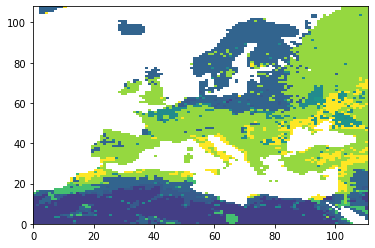

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.pcolormesh(field_anom_sig_log[-1,:,:],vmin=.5,vmax=1.)

In [81]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import os
import shutil
import time
from glob import glob
from scipy.stats import pearsonr

import sys
extra_path = '/p/project/cjibg36/kaandorp2/Git/SLOTH' 
if extra_path not in sys.path:
    sys.path.append(extra_path)

from sloth.IO import readSa, writeSa

In [2]:
file_indi = '/p/project/cjibg36/kaandorp2/TSMP_patched/tsmp_cordex_111x108/input_pf/EUR-11_TSMP_FZJ-IBG3_CLMPFLDomain_111x108_INDICATOR_regridded_rescaled_SoilGrids250-v2017_BGR3_alv.sa'

data_indi = readSa(file_indi)

indi_names = ['TC%2.2i' %i for i in range(1,13)] + ['Allv'] + ['BGR%1.1i' %i for i in range(1,7)] + ['Lake','Sea']
indi_nr = np.setdiff1d(np.arange(1,len(indi_names)+2),np.array([20]) ) #array starting at 1, to 22 and without 20
indi_nr_estim = np.setdiff1d(np.arange(1,len(indi_names)+2),np.array([13,20,21,22]) ) #which indicators to estimate: don't estimate Allv, water
indi_perm = [0.267787,0.043832,0.015951,0.005021,0.0076,0.01823,0.005493,0.00341,0.004632,0.004729,0.004007,0.006149,
             0.1,
             0.1,0.05,0.01,0.005,0.001,0.0005,
             1e-5,1e-5]
indi_logKs     = [2.808,2.022,1.583,1.081,1.261,1.641,
                  1.120,0.913,1.046,1.055,0.983,1.169]
indi_logKs_sig = [0.590,0.640,0.660,0.920,0.740,0.270,
                  0.850,1.090,0.760,0.890,0.570,0.920]
indi_names_full = ['sand','loamy sand','sandy loam','loam','silt loam','silt',
                   'sandy clay loam','clay loam','silty clay loam','sandy clay','silty clay','clay'] + ['Alluvium'] + ['BGR%1.1i' %i for i in range(1,7)] + ['Lake','Sea']
indi_dz = 2*np.array([9.0,7.5,5.0,5.0,2.0,0.5,0.35,0.25,0.15,0.10,0.065,0.035,0.025,0.015,0.01])
indi_depths = np.flip(np.cumsum(np.flip(indi_dz)))

In [3]:
indi_depths

array([6.0e+01, 4.2e+01, 2.7e+01, 1.7e+01, 7.0e+00, 3.0e+00, 2.0e+00,
       1.3e+00, 8.0e-01, 5.0e-01, 3.0e-01, 1.7e-01, 1.0e-01, 5.0e-02,
       2.0e-02])

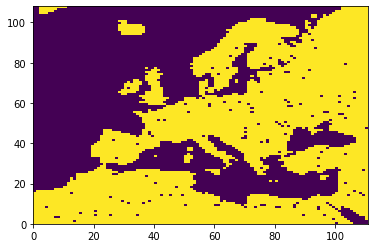

In [5]:
%matplotlib inline
plt.figure()
plt.pcolormesh(np.isin(data_indi,indi_nr_estim)[-1,:,:])

In [6]:
field_Ks_log = np.zeros(data_indi.shape)
field_Ks_sig_log = np.zeros(data_indi.shape)
sig_log_standard = 0.74 #set standard uncertainty to mean of Rosetta values

for i1,indicator in enumerate(indi_nr):
    mask = (data_indi == indicator)
    
    if indicator <= 12: #surface layers, soilgrids
        # use Rosetta: values are given in log10(cm/day) -> convert to log10(m/h) for ParFlow
        field_Ks_log[mask] = indi_logKs[i1] - np.log10(100*24) #go from cm/day (Rosetta) to m/h (ParFlow)
        field_Ks_sig_log[mask] = indi_logKs_sig[i1] # no unit transform necessary here (log space is already relative)
    elif indicator < 20: # deep subsurface
        # use standard ParFlow values. Take the log10, and use predefined uncertainty
        field_Ks_log[mask] = np.log10(indi_perm[i1])
        field_Ks_sig_log[mask] = sig_log_standard
    else: #lake and ocean
        field_Ks_log[mask] = np.log10(indi_perm[i1])
        field_Ks_sig_log[mask] = np.nan
        
    
    # field_Ks[mask] = ( (10**(logKs)) / (100*24)) #go from cm/day (Rosetta) to m/h (ParFlow)
    
assert (field_Ks_log==0).sum() == 0

Text(0.5, 1.0, 'Permeability uncertainty log10([m/h]), upper layer')

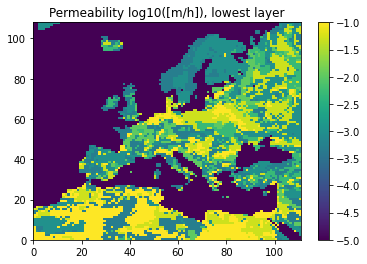

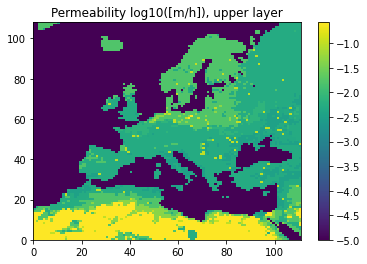

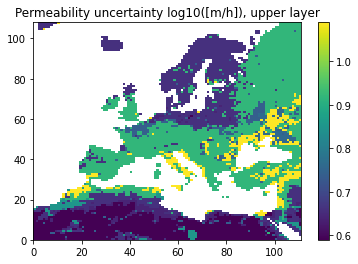

In [7]:
%matplotlib inline
plt.figure()
plt.pcolormesh(field_Ks_log[0,:,:] )
plt.colorbar()
plt.title('Permeability log10([m/h]), lowest layer')

plt.figure()
plt.pcolormesh(field_Ks_log[-1,:,:] )
plt.colorbar()
plt.title('Permeability log10([m/h]), upper layer')

plt.figure()
plt.pcolormesh(field_Ks_sig_log[-1,:,:] )
plt.colorbar()
plt.title('Permeability uncertainty log10([m/h]), upper layer')

In [25]:
# select z-indices for which the Kriged fields will be created. For the rest of the indices, interpolate the Ks values
i_sample_z = np.arange(field_Ks_log.shape[0]-1,0,-3)
if 0 not in i_sample_z:
    i_sample_z = np.append(i_sample_z,0)
i_sample_z = np.flip(i_sample_z)

# initialize list containing the Gaussian process regressors

# indices of layers for which linear interpolation is used
i_interp_z = np.setxor1d(i_sample_z,np.arange(0,field_Ks_log.shape[0]))


In [76]:
i_sample_z

array([ 0,  2,  5,  8, 11, 14])

In [74]:
# generate control (training) points, and holdout (validation) points per layer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern

# for i1, i_sample zip enumerate(np.arange(field_Ks_log.shape[0]),np.arange(field_Ks_log.shape[0])):    
def fit_gprs(i_sample_z):
    
    gprs_ = {} #[[]]*len(i_sample_z)

    for i1, i_sample in enumerate(i_sample_z): #only train the GPR on several layers
        # 1) take samples in x,y,z dir: _c_ are control points (i.e. used for training the regressor)
        # i_z = np.flip(np.arange(field_Ks_log.shape[0]-1,0,-2)) #flip in order to start sampling at the surface
        i_c_z = np.array([i_sample])
        i_c_lat = np.arange(0,field_Ks_log.shape[1],5)
        i_c_lon = np.arange(0,field_Ks_log.shape[2],5)

        # _v_ are the validation points to check performance
        i_v_z = np.array([i_sample])
        i_v_lat = np.setxor1d(i_c_lat, np.arange(0,field_Ks_log.shape[1]) )
        i_v_lon = np.setxor1d(i_c_lon, np.arange(0,field_Ks_log.shape[2]) )

        X_c_all = np.meshgrid(i_c_z,i_c_lat,i_c_lon,indexing='ij')
        # mask_c_land = ~np.isnan(field_Ks_sig_log[np.ix_(i_c_z,i_c_lat,i_c_lon)])
        mask_c_land = np.isin(data_indi,indi_nr_estim)[np.ix_(i_c_z,i_c_lat,i_c_lon)]
        X_train = np.array([X_c_all[0][mask_c_land],
                           X_c_all[1][mask_c_land],
                           X_c_all[2][mask_c_land]]).T[:,1:]

        X_v_all = np.meshgrid(i_v_z,i_v_lat,i_v_lon,indexing='ij')
        mask_v_land = np.isin(data_indi,indi_nr_estim)[np.ix_(i_v_z,i_v_lat,i_v_lon)]
        X_val = np.array([X_v_all[0][mask_v_land],
                           X_v_all[1][mask_v_land],
                           X_v_all[2][mask_v_land]]).T[:,1:]

        # 2) get indicator at sample, corresponding Ks and Ks_sigma
        Y_train = field_Ks_log[np.ix_(i_c_z,i_c_lat,i_c_lon)][mask_c_land]
        Y_sigma = field_Ks_sig_log[np.ix_(i_c_z,i_c_lat,i_c_lon)][mask_c_land]

        Y_val = field_Ks_log[np.ix_(i_v_z,i_v_lat,i_v_lon)][mask_v_land]

        # 3) fit Gaussian process regressor
        # kernel = 1.0 * RBF(length_scale=5)
        kernel = 1.0 * Matern(length_scale=20,nu=1.5,length_scale_bounds='fixed')

        gprs_[i_sample] = GaussianProcessRegressor(kernel=kernel,alpha=1.*(Y_sigma**2))
        gprs_[i_sample].fit(X_train, Y_train)
    return gprs_, X_train

gprs, X_train = fit_gprs(i_sample_z)
gprs_i, _ = fit_gprs(i_interp_z)

In [33]:
len(i_interp_z)
len(gprs_i)

9

In [71]:
# evaluate fit, predict for whole domain (X_test)
X = np.meshgrid(np.arange(0,field_Ks_log.shape[1]),
                np.arange(0,field_Ks_log.shape[2]),indexing='ij')
mask_land = (data_indi[-1,:] < 20)
X_test = np.array([X[0][mask_land],
                   X[1][mask_land]]).T

/tmp/ipykernel_19925/189250840.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


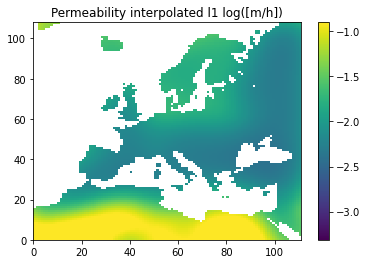

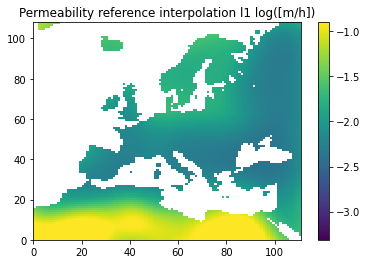

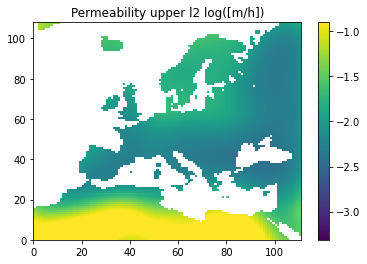

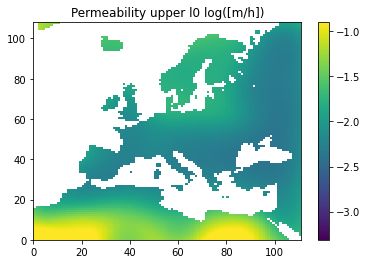

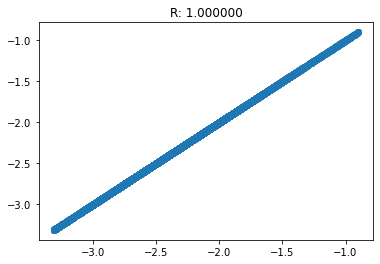

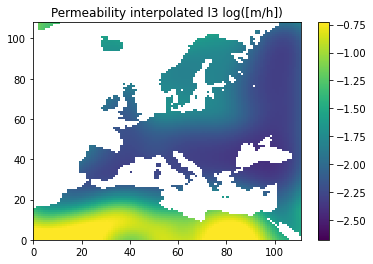

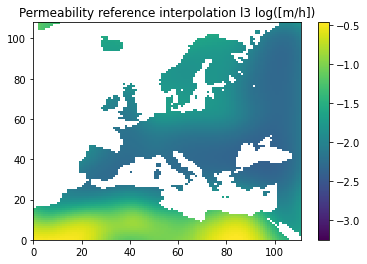

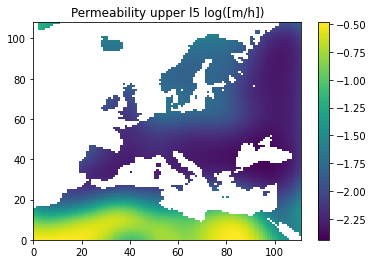

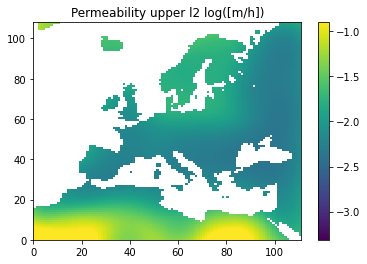

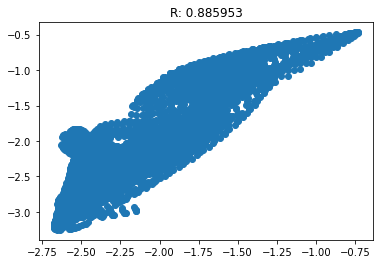

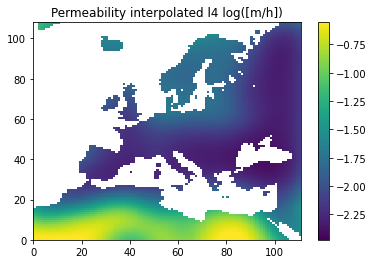

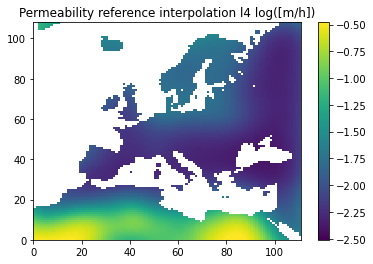

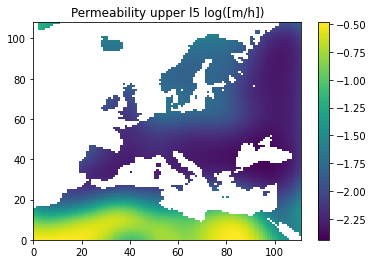

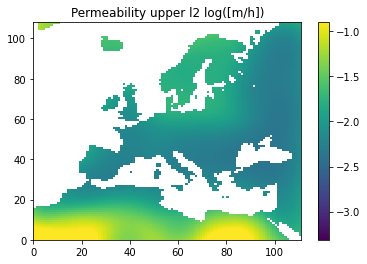

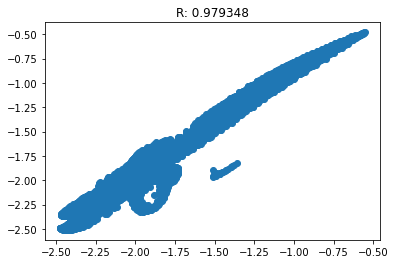

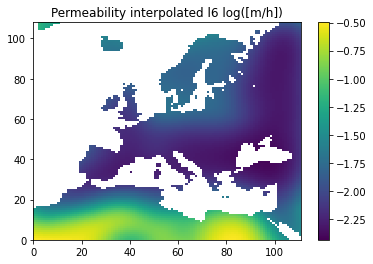

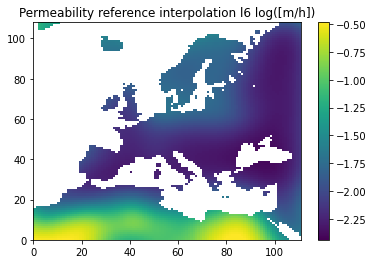

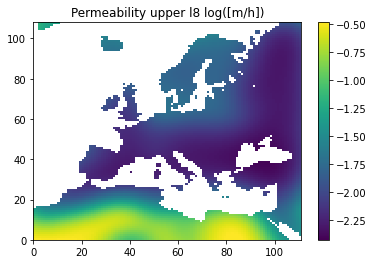

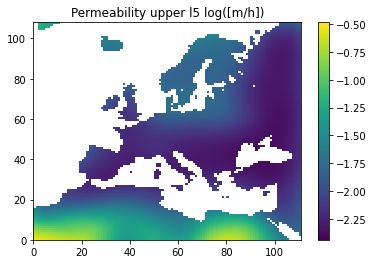

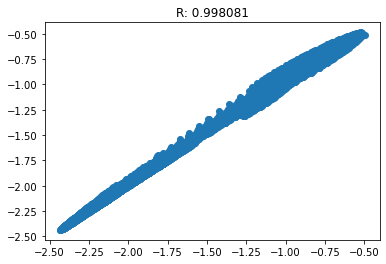

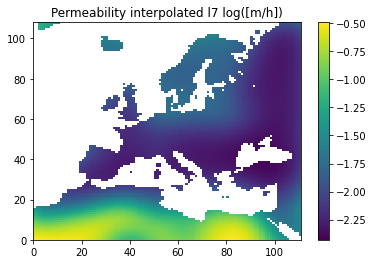

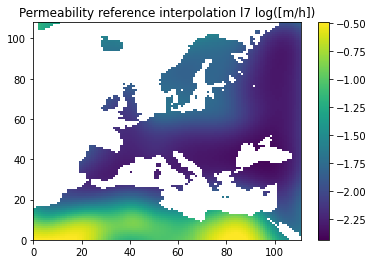

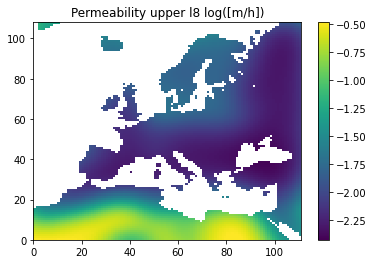

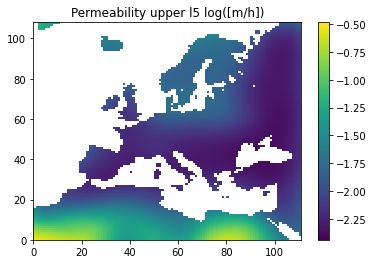

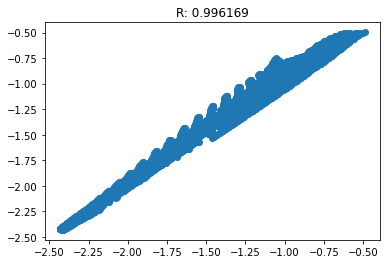

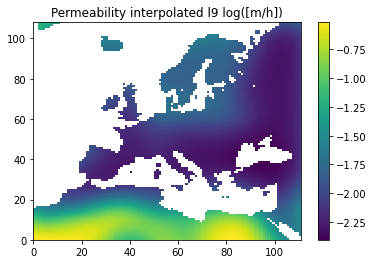

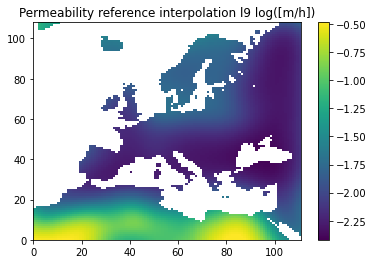

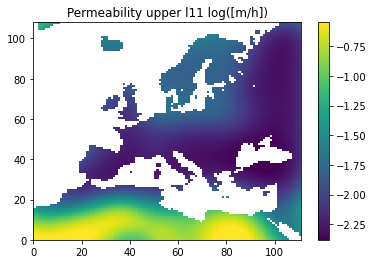

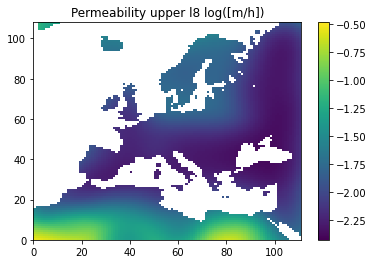

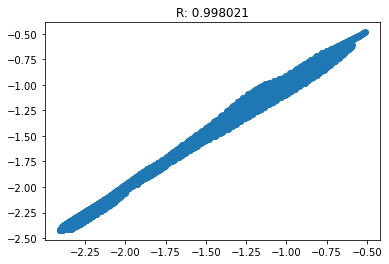

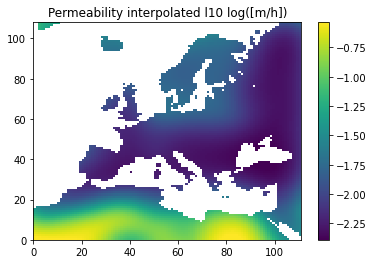

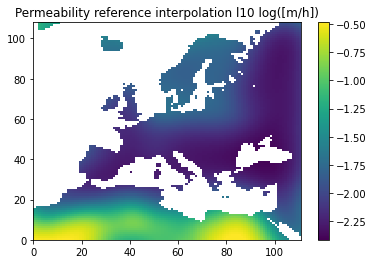

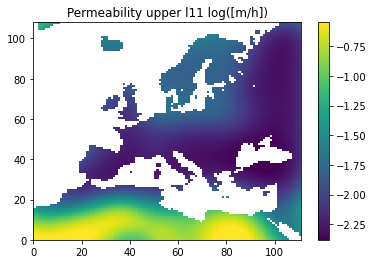

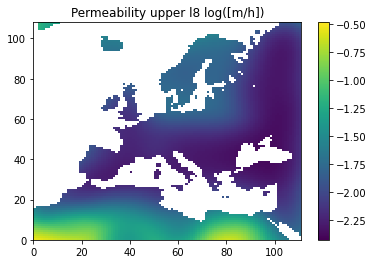

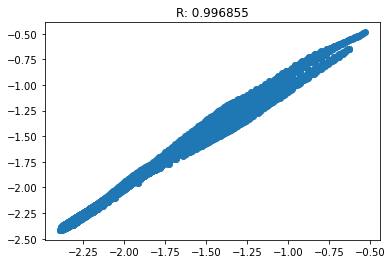

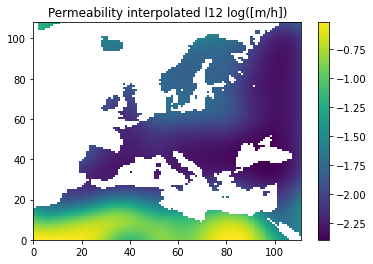

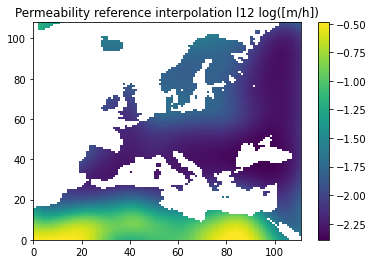

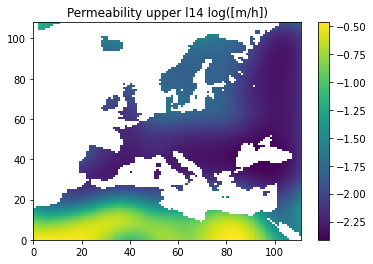

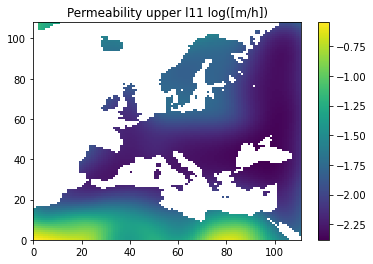

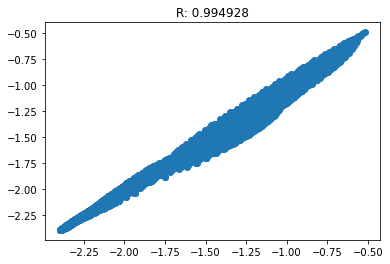

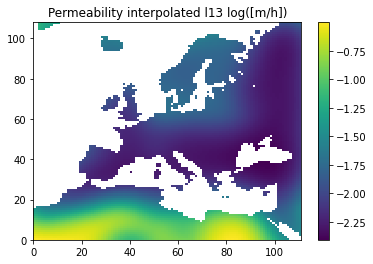

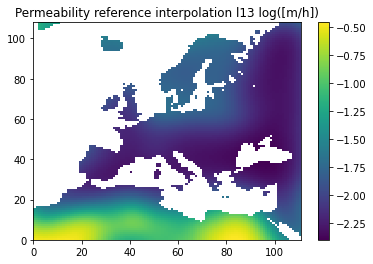

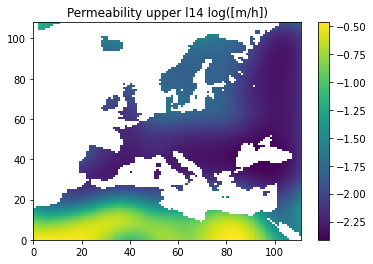

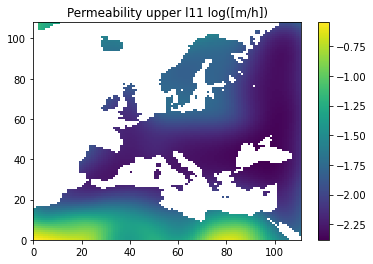

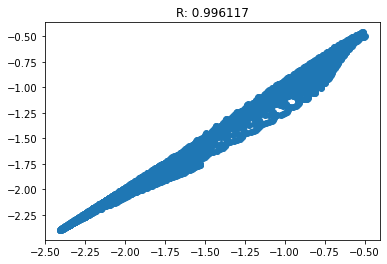

In [72]:
test_perf = True

Ks_field_interp = np.nan*np.zeros(mask_land.shape)
Ks_field_upper = np.nan*np.zeros(mask_land.shape)
Ks_field_lower = np.nan*np.zeros(mask_land.shape)

if test_perf:
    Ks_field_ref = np.nan*np.zeros(mask_land.shape)

i_lower_old = np.inf
field_upper = np.zeros(X_test.shape)
field_lower = np.zeros(X_test.shape)
for i_interp in i_interp_z:
    i_lower = i_sample_z[np.digitize(i_interp,i_sample_z) - 1]
    i_upper = i_sample_z[np.digitize(i_interp,i_sample_z)]
    # i_lower = np.digitize(i_interp,i_sample_z) - 1
    # i_upper = np.digitize(i_interp,i_sample_z)
    
    if i_lower == i_lower_old:
        # predictions for upper/lower fields already made, skip
        pass
    else:
        Ks_upper = gprs[i_upper].predict(X_test)
        Ks_lower = gprs[i_lower].predict(X_test)
        
        Ks_field_upper[mask_land] = Ks_upper
        Ks_field_lower[mask_land] = Ks_lower
        i_lower_old = i_lower
    
    if test_perf:
        Ks_ref = gprs_i[i_interp].predict(X_test)
        Ks_field_ref[mask_land] = Ks_ref
    
    # interpolate between lower/upper field
    z_upper = indi_depths[i_upper]
    z_lower = indi_depths[i_lower]
    z_interp = indi_depths[i_interp]
    
    assert(z_upper < z_lower)
    assert(z_interp > z_upper)
    
    Ks_interp = ( ((z_interp - z_upper) / (z_lower - z_upper)) * Ks_lower) + ( ((z_lower - z_interp) / (z_lower - z_upper)) * Ks_upper)
    # field_interp[mask_land] = Ks_interp ????
    Ks_field_interp[mask_land] = Ks_interp
    

    plt.figure()
    plt.pcolormesh(Ks_field_interp[:,:])
    plt.colorbar()
    plt.title('Permeability interpolated l%i log([m/h])' %i_interp)

    plt.figure()
    plt.pcolormesh(Ks_field_ref[:,:])
    plt.colorbar()
    plt.title('Permeability reference interpolation l%i log([m/h])' %i_interp)
    
    plt.figure()
    plt.pcolormesh(Ks_field_upper[:,:])
    plt.colorbar()
    plt.title('Permeability upper l%i log([m/h])' %i_upper)
    
    plt.figure()
    plt.pcolormesh(Ks_field_lower[:,:])
    plt.colorbar()
    plt.title('Permeability upper l%i log([m/h])' %i_lower)
    
    plt.figure()
    plt.plot(Ks_interp,Ks_ref,'o')
    plt.title('R: %f' % pearsonr(Ks_interp,Ks_ref)[0] )

In [64]:
i_interp

1

Text(0.5, 1.0, 'Permeability log([m/h])')

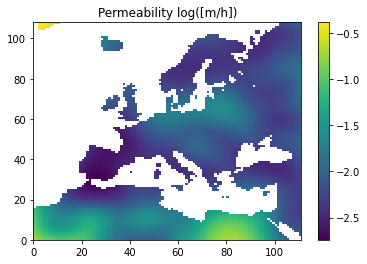

In [21]:
plt.figure()
plt.pcolormesh(Ks_field_interp[:,:])
plt.colorbar()
plt.title('Permeability log([m/h])')

In [158]:
z_upper
z_lower
z_interp
field_interp.shape

(6503,)

In [140]:
indi_depths

array([6.0e+01, 4.2e+01, 2.7e+01, 1.7e+01, 7.0e+00, 3.0e+00, 2.0e+00,
       1.3e+00, 8.0e-01, 5.0e-01, 3.0e-01, 1.7e-01, 1.0e-01, 5.0e-02,
       2.0e-02])

In [132]:
i_sample_z

array([ 0,  2,  5,  8, 11, 14])

In [88]:
# 3) fit Gaussian process regressor
# kernel = 1.0 * RBF(length_scale=5)
kernel = 1.0 * Matern(length_scale=20,nu=1.5,length_scale_bounds='fixed')

gpr = GaussianProcessRegressor(kernel=kernel,alpha=1.*(Y_sigma**2))
gpr.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=array([0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.54...
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476, 0.5476,
       0.5476, 0.5476, 0.5476, 0.5476, 0.5476]),
                         kernel=1**2 * Matern(length_scale=20, nu=1.5))

In [89]:
# 4) performance
X = np.meshgrid(np.arange(0,field_Ks_log.shape[1]),
                np.arange(0,field_Ks_log.shape[2]),indexing='ij')
mask_land = (data_indi[-1,:] < 20)
X_test = np.array([X[0][mask_land],
                   X[1][mask_land]]).T

Y_hat_val = gpr.predict(X_val)
Y_hat_test = gpr.predict(X_test)

Text(0.5, 1.0, 'Permeability log([m/h])')

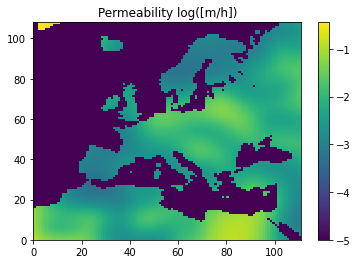

In [90]:
Ks_pred = np.nan*np.zeros(data_indi[-1,:].shape)
Ks_pred[mask_land] = Y_hat_test
Ks_pred[~mask_land] = -5

%matplotlib inline
plt.figure()
plt.pcolormesh(Ks_pred[:,:])
plt.colorbar()
plt.title('Permeability log([m/h])')


Text(0.5, 1.0, 'Pearson R: 0.395590')

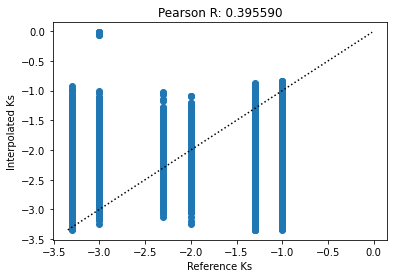

In [86]:
min_ = min(min(Y_val),min(Y_hat_val))
max_ = max(max(Y_val),max(Y_hat_val))
plt.figure()
plt.plot(Y_val.ravel(),Y_hat_val.ravel(),'o')
plt.plot([min_,max_],[min_,max_],'k:')
plt.xlabel('Reference Ks')
plt.ylabel('Interpolated Ks')
plt.title('Pearson R: %f' % pearsonr(Y_val,Y_hat_val)[0])

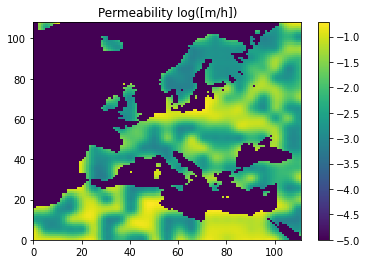

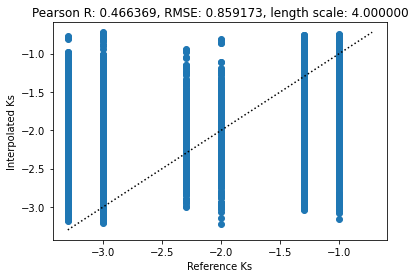

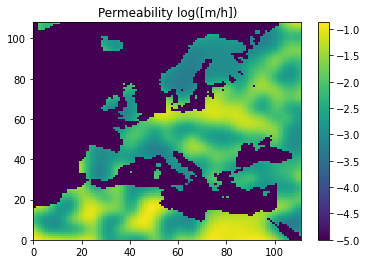

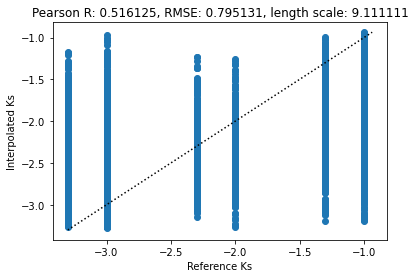

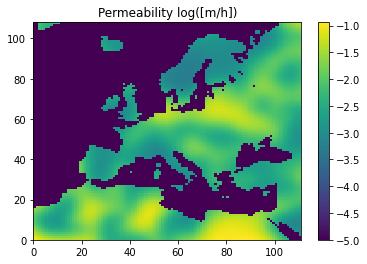

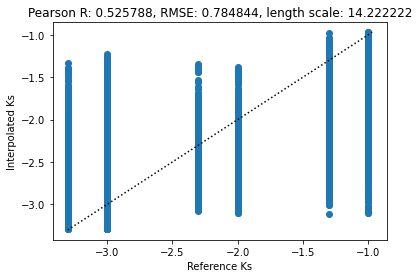

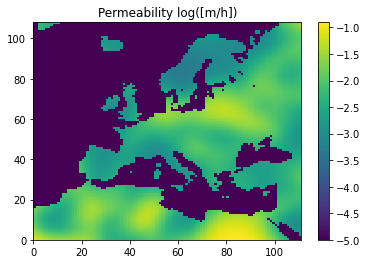

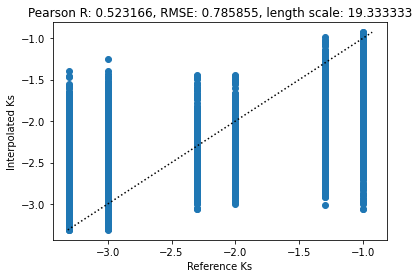

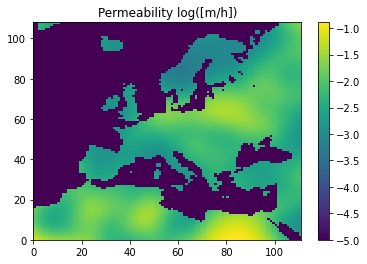

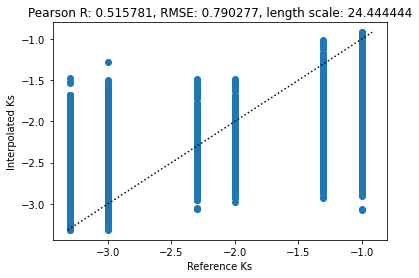

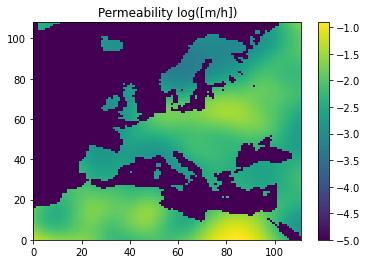

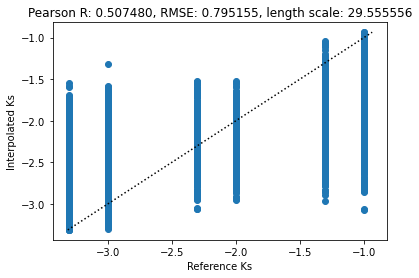

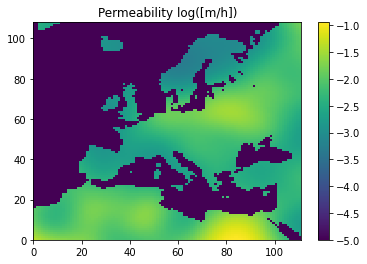

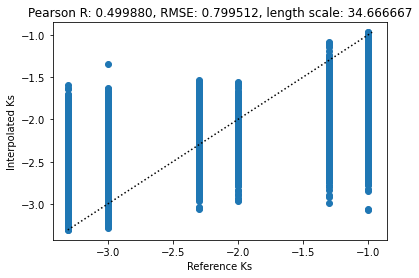

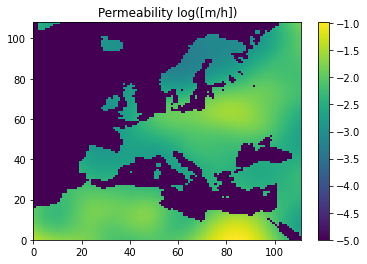

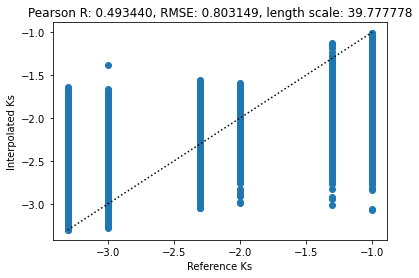

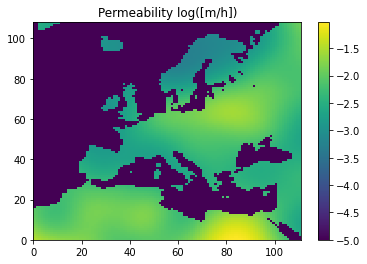

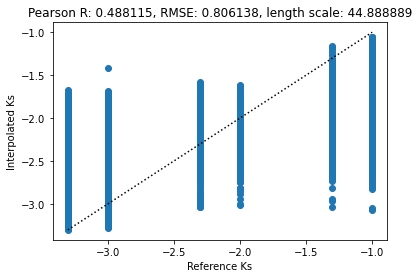

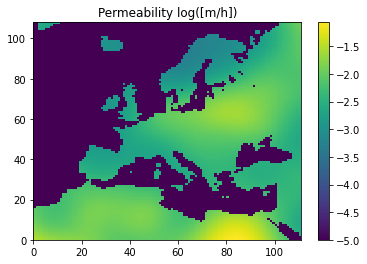

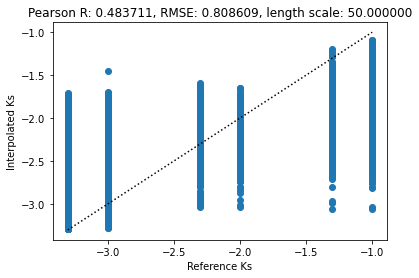

In [80]:
%matplotlib inline
i_sample = 0

i_c_z = np.array([i_sample])
i_c_lat = np.arange(0,field_Ks_log.shape[1],5)
i_c_lon = np.arange(0,field_Ks_log.shape[2],5)

# _v_ are the validation points to check performance
i_v_z = np.array([i_sample])
i_v_lat = np.setxor1d(i_c_lat, np.arange(0,field_Ks_log.shape[1]) )
i_v_lon = np.setxor1d(i_c_lon, np.arange(0,field_Ks_log.shape[2]) )

X_c_all = np.meshgrid(i_c_z,i_c_lat,i_c_lon,indexing='ij')
# mask_c_land = ~np.isnan(field_Ks_sig_log[np.ix_(i_c_z,i_c_lat,i_c_lon)])
mask_c_land = np.isin(data_indi,indi_nr_estim)[np.ix_(i_c_z,i_c_lat,i_c_lon)]
X_train = np.array([X_c_all[0][mask_c_land],
                   X_c_all[1][mask_c_land],
                   X_c_all[2][mask_c_land]]).T[:,1:]

X_v_all = np.meshgrid(i_v_z,i_v_lat,i_v_lon,indexing='ij')
mask_v_land = np.isin(data_indi,indi_nr_estim)[np.ix_(i_v_z,i_v_lat,i_v_lon)]
X_val = np.array([X_v_all[0][mask_v_land],
                   X_v_all[1][mask_v_land],
                   X_v_all[2][mask_v_land]]).T[:,1:]

# 2) get indicator at sample, corresponding Ks and Ks_sigma
Y_train = field_Ks_log[np.ix_(i_c_z,i_c_lat,i_c_lon)][mask_c_land]
Y_sigma = field_Ks_sig_log[np.ix_(i_c_z,i_c_lat,i_c_lon)][mask_c_land]

Y_val = field_Ks_log[np.ix_(i_v_z,i_v_lat,i_v_lon)][mask_v_land]

# 3) fit Gaussian process regressor
# kernel = 1.0 * RBF(length_scale=5)
kernel = 1.0 * Matern(length_scale=20,nu=1.5,length_scale_bounds='fixed')

gpr = GaussianProcessRegressor(kernel=kernel,alpha=1.*(Y_sigma**2))
gpr.fit(X_train, Y_train)
        
        
for l_ in np.linspace(4,50,10):

    # 3) fit Gaussian process regressor
    # kernel = 1.0 * RBF(length_scale=5)
    kernel = 1.0 * Matern(length_scale=l_,nu=1.5,length_scale_bounds='fixed')

    gpr = GaussianProcessRegressor(kernel=kernel,alpha=1.*(Y_sigma**2))
    gpr.fit(X_train, Y_train)
    
    # 4) performance
    X = np.meshgrid(np.arange(0,field_Ks_log.shape[1]),
                    np.arange(0,field_Ks_log.shape[2]),indexing='ij')
    mask_land = (data_indi[-1,:] < 20)
    X_test = np.array([X[0][mask_land],
                       X[1][mask_land]]).T

    Y_hat_val = gpr.predict(X_val)
    Y_hat_test = gpr.predict(X_test)
    
    # 5) plot
    Ks_pred = np.nan*np.zeros(data_indi[-1,:].shape)
    Ks_pred[mask_land] = Y_hat_test
    Ks_pred[~mask_land] = -5

    plt.figure()
    plt.pcolormesh(Ks_pred[:,:])
    plt.colorbar()
    plt.title('Permeability log([m/h])')
    
    RMSE = np.sqrt(np.mean( (Y_val - Y_hat_val)**2))
    min_ = min(min(Y_val),min(Y_hat_val))
    max_ = max(max(Y_val),max(Y_hat_val))
    plt.figure()
    plt.plot(Y_val.ravel(),Y_hat_val.ravel(),'o')
    plt.plot([min_,max_],[min_,max_],'k:')
    plt.xlabel('Reference Ks')
    plt.ylabel('Interpolated Ks')
    plt.title('Pearson R: %f, RMSE: %f, length scale: %f' % (pearsonr(Y_val,Y_hat_val)[0],RMSE,l_))

(277, 2)


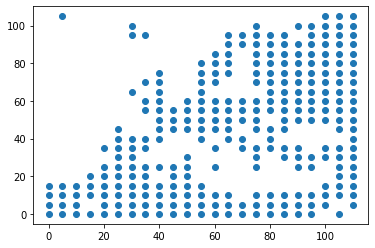

In [79]:
plt.figure()
plt.plot(X_train[:,1],X_train[:,0],'o')
print(X_train.shape)

In [61]:
X_train.shape

(186, 2)